## This notebook is for data augmentation and data visualisation

In [17]:
import os
import json
import cv2
import random

In [18]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np

# Dataset Overview: LIVECell
LIVECell (Label-free In Vitro image Examples of Cells) is a large-scale, high-quality dataset designed for deep learning tasks in microscopic image analysis, specifically Instance Segmentation and Cell Counting. Developed by Sartorius and DFKI, it addresses the scarcity of annotated data for label-free (phase-contrast) microscopy images.

Unlike traditional datasets that rely on fluorescent staining (which can be toxic to cells), LIVECell uses Phase-Contrast imaging. This allows for non-invasive monitoring of cell cultures over time but presents a significant Computer Vision challenge due to low contrast and complex visual artifacts.

Key Characteristics
Scale: It is one of the largest datasets of its kind, containing over 1.6 million manually annotated cells across 5,239 images.
Modality: The images are Phase-Contrast (grayscale), meaning the model must rely on texture, shape, and light diffraction patterns rather than distinct color cues found in fluorescence images.
Diversity: The dataset encompasses 8 distinct cell lines, ensuring high morphological variety. This tests a model's ability to generalize across different cell shapes (from round and isolated to flat and clustered).

Data Composition
The dataset includes images of the following 8 cell lines, which vary significantly in size, shape, and growth density:
A172 (Glioblastoma)
BT-474 (Breast Cancer)
BV-2 (Microglia)
Huh7 (Hepatocellular Carcinoma)
MCF7 (Breast Cancer)
SH-SY5Y (Neuroblastoma)
SkBr3 (Breast Cancer)
SK-OV-3 (Ovarian Cancer)

Technical Specifications
Image Format: .tif (Tagged Image File Format), grayscale.
Resolution: Typically 704 × 520 pixels.
Annotation Format: COCO JSON. Each cell is annotated as a distinct polygon (instance segmentation mask), which allows for precise counting (1 polygon = 1 cell).
Data Split: The dataset is pre-split by the authors into:
    Training: ~70% (approx. 3,200 images)
    Validation: ~15% (approx. 500 images)
    Testing: ~15% (approx. 1,500 images)

Challenges for Computer Vision
For your cell counting project, LIVECell presents specific difficulties:
High Density & Occlusion: Cells often grow in clusters (confluence), overlapping or touching each other. Distinguishing the boundary between two touching cells is the hardest part of the counting task.
Visual Artifacts: Phase-contrast images often contain debris, scratches, or "halo" artifacts around cells that can be confused with cell boundaries.
Imbalance: Some images contain fewer than 50 cells, while others contain over 2,000, requiring the model to handle extreme variations in object density.

Quick Summary Table (for slides/reports)

| Feature | Description |
| :--- | :--- |
| Name | LIVECell (Label-free In Vitro image Examples of Cells) |
| Total Images | ~5,239 |
| Total Annotations | ~1,616,000+ |
| Classes | 8 Cell Lines (Single Class detection, Multi-domain) |
| Imaging Type | Phase-Contrast Microscopy (Grayscale) |
| Annotation Type | Polygons (COCO Format) |
| Primary Task | Instance Segmentation / Object Counting |

In [23]:
JSON_PATH = "jsons/livecell_coco_val.json"
LIVECell_ROOT = "dataset/images 2/livecell_train_val_images"

In [26]:
def visualize_livecell_data():
    print(f"Loading annotations from: {JSON_PATH}")
    print("Please wait, parsing the huge JSON file... (this can take 10-30 seconds)")
    
    # Initialize COCO api (this parses the JSON)
    coco = COCO(JSON_PATH)
    
    # Get all image IDs stored in the JSON
    img_ids = coco.getImgIds()
    total_imgs = len(img_ids)
    print(f"\nSuccess! Found {total_imgs} images in the annotation file.")

    # Pick a random image to display
    random_index = random.randint(0, len(img_ids) - 1)
    img_info = coco.loadImgs(img_ids[random_index])[0]
    
    file_name = img_info['file_name']
    print(f"\nSelected Image: {file_name}")

    # --- PATH CONSTRUCTION LOGIC ---
    # LIVECell structure usually puts images in subfolders named after the cell type.
    # The cell type is usually the first part of the filename (e.g. 'A172_...')
    cell_type = file_name.split('_')[0] 
    
    # Try to locate the image
    # Option A: It's directly in the root folder
    full_path = os.path.join(LIVECell_ROOT, file_name)
    
    # Option B: It's in a subfolder (Standard LIVECell structure)
    if not os.path.exists(full_path):
        full_path = os.path.join(LIVECell_ROOT, cell_type, file_name)
        
    if not os.path.exists(full_path):
        print(f"ERROR: Could not find image file at: {full_path}")
        print(f"Please check your LIVECell_ROOT path: {LIVECell_ROOT}")
        return

    # Load the image
    image = cv2.imread(full_path)
    if image is None:
        print("Error reading the TIF file. It might be corrupted or the path is wrong.")
        return
        
    # Convert from BGR (OpenCV default) to RGB (Matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the specific annotations for this image ID
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)
    print(f"Number of cells annotated in this image: {len(anns)}")

    # --- PLOTTING ---
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{file_name} \nCount: {len(anns)} cells", fontsize=16)

    # This function from pycocotools draws the polygons on top of the plot
    coco.showAnns(anns, draw_bbox=False)
    
    plt.show()

Loading annotations from: jsons/livecell_coco_val.json
Please wait, parsing the huge JSON file... (this can take 10-30 seconds)
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!

Success! Found 570 images in the annotation file.

Selected Image: BV2_Phase_C4_1_00d16h00m_4.tif
Number of cells annotated in this image: 152


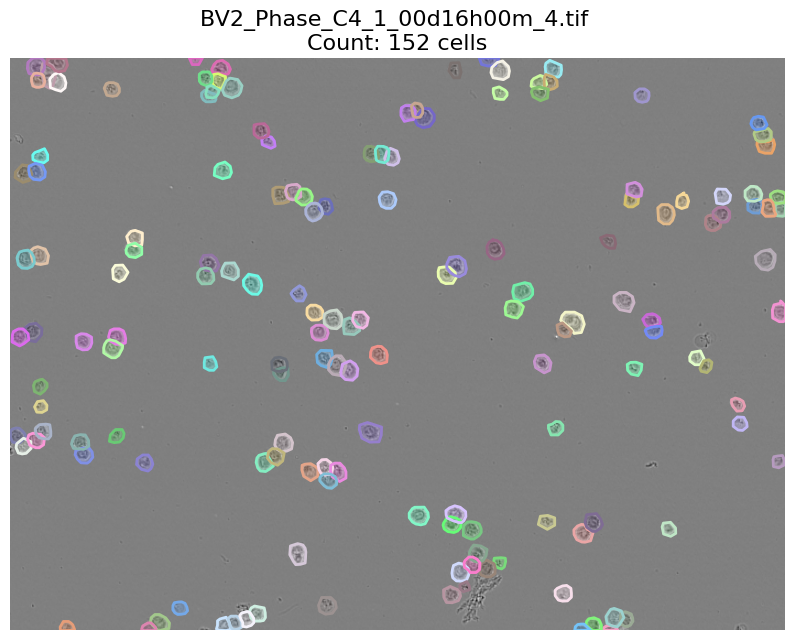

In [27]:
visualize_livecell_data()

### Description of the LIVECell dataset

In [30]:
from collections import defaultdict

# ================= CONFIGURATION =================
# Folder containing your JSON files
BASE_PATH = 'jsons'

# =================================================

def analyze_split(split_name, json_file):
    full_path = os.path.join(BASE_PATH, json_file)
    
    if not os.path.exists(full_path):
        print(f"Skipping {split_name}: File not found at {full_path}")
        return

    print(f"\n{'='*20} ANALYZING {split_name} {'='*20}")
    print(f"Loading {json_file}...")
    
    # Load COCO object
    coco = COCO(full_path)
    
    # Get IDs
    img_ids = coco.getImgIds()
    ann_ids = coco.getAnnIds()
    
    # 1. BASIC COUNTS
    total_imgs = len(img_ids)
    total_anns = len(ann_ids)
    
    print(f"\n--- General Stats ---")
    print(f"Total Images:      {total_imgs}")
    print(f"Total Cells:       {total_anns}")
    
    # 2. DENSITY ANALYSIS (Cells per Image)
    counts = []
    cell_type_counts = defaultdict(int)
    
    # We loop through images to count annotations per image
    # and identify cell types from filenames
    for i_id in img_ids:
        # Get annotations for this specific image
        a_ids = coco.getAnnIds(imgIds=i_id)
        count = len(a_ids)
        counts.append(count)
        
        # Get filename to identify Cell Type (e.g., "A172_Phase...")
        img_info = coco.loadImgs(i_id)[0]
        fname = img_info['file_name']
        
        # Extract cell type (usually the first part of the filename)
        # LIVECell format is usually "Type_Phase..."
        cell_type = fname.split('_')[0]
        cell_type_counts[cell_type] += 1

    counts = np.array(counts)
    
    print(f"\n--- Density Stats (Cells per Image) ---")
    print(f"Average Count:     {np.mean(counts):.2f}")
    print(f"Median Count:      {np.median(counts):.2f}")
    print(f"Min Count:         {np.min(counts)}")
    print(f"Max Count:         {np.max(counts)}")
    
    # 3. CELL TYPE DISTRIBUTION
    print(f"\n--- Image Distribution by Cell Type ---")
    # Sort by cell type name for cleaner output
    for c_type in sorted(cell_type_counts.keys()):
        n_imgs = cell_type_counts[c_type]
        # Calculate percentage of dataset
        pct = (n_imgs / total_imgs) * 100
        print(f"{c_type:<10}: {n_imgs} images ({pct:.1f}%)")

    

In [31]:
FILES = [
    ['TRAIN','livecell_coco_train.json'],
    ['TEST','livecell_coco_test.json'],
    ['VALIDATION','livecell_coco_val.json']
]

In [33]:
analyze_split(FILES[0][0], FILES[0][1])



==================== ANALYZING TRAIN ====================
Loading livecell_coco_train.json...
loading annotations into memory...
Done (t=4.25s)
creating index...
index created!

--- General Stats ---
Total Images:      3253
Total Cells:       1018576

--- Density Stats (Cells per Image) ---
Average Count:     313.12
Median Count:      205.00
Min Count:         1
Max Count:         3015

--- Image Distribution by Cell Type ---
A172      : 388 images (11.9%)
BT474     : 429 images (13.2%)
BV2       : 386 images (11.9%)
Huh7      : 390 images (12.0%)
MCF7      : 469 images (14.4%)
SHSY5Y    : 449 images (13.8%)
SKOV3     : 293 images (9.0%)
SkBr3     : 449 images (13.8%)


In [34]:
analyze_split(FILES[1][0], FILES[1][1])


==================== ANALYZING TEST ====================
Loading livecell_coco_test.json...
loading annotations into memory...
Done (t=2.23s)
creating index...
index created!

--- General Stats ---
Total Images:      1564
Total Cells:       462261

--- Density Stats (Cells per Image) ---
Average Count:     295.56
Median Count:      197.00
Min Count:         2
Max Count:         1874

--- Image Distribution by Cell Type ---
A172      : 152 images (9.7%)
BT474     : 168 images (10.7%)
BV2       : 152 images (9.7%)
Huh7      : 216 images (13.8%)
MCF7      : 184 images (11.8%)
SHSY5Y    : 176 images (11.3%)
SKOV3     : 340 images (21.7%)
SkBr3     : 176 images (11.3%)


In [35]:
analyze_split(FILES[2][0], FILES[2][1])


==================== ANALYZING VALIDATION ====================
Loading livecell_coco_val.json...
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!

--- General Stats ---
Total Images:      570
Total Cells:       181610

--- Density Stats (Cells per Image) ---
Average Count:     318.61
Median Count:      211.00
Min Count:         1
Max Count:         2904

--- Image Distribution by Cell Type ---
A172      : 68 images (11.9%)
BT474     : 75 images (13.2%)
BV2       : 70 images (12.3%)
Huh7      : 66 images (11.6%)
MCF7      : 82 images (14.4%)
SHSY5Y    : 79 images (13.9%)
SKOV3     : 51 images (8.9%)
SkBr3     : 79 images (13.9%)


## The Strategic Importance of Balanced Cell Distribution
The fact that the Train, Validation, and Test sets contain a roughly equal population of all 8 cell lines (Stratified Split) is crucial for three reasons:
1. Prevents Morphological Bias:
Different cell lines have vastly different shapes (e.g., A172 are long and spiky, while MCF7 are round and clustered). Because the training set is balanced, the model is forced to learn features common to all cells rather than overfitting to the specific shape of the most common cell type.
2. Ensures “Universal” Generalization:
If the dataset were dominated by one easy-to-count cell type, the model might achieve high accuracy while failing completely on harder, irregular cells. The balanced distribution ensures your model becomes a robust, universal cell counter capable of handling various biological structures, rather than just memorizing one specific pattern.
3. Guarantees Honest Evaluation:
A balanced Test Set ensures your final accuracy score is realistic. It prevents the “accuracy paradox,” where a model looks good simply because it predicts the easy majority class correctly while failing on the difficult minority classes. If your model scores 90% accuracy on this balanced test set, you know it is genuinely performing well across the board.